In [1]:
import os
import numpy as np
import pandas as pd
import scipy.sparse as ss

from tqdm import tqdm,trange
from datetime import datetime

import sys
import importlib
sys.path.append('../d03_src/')
import vars
import utils
from utils import RMSE, diagonal, offdiagonal, flat, replace_infinite
from scipy.stats import pearsonr, spearmanr, linregress, sem
import process_infutor as pri
import process_census as prc
import optimization as opt
import evaluation as eval
import visualization as viz

import statsmodels.api as sm
import statsmodels.formula.api as smf

import geopandas as gpd
from pygris.utils import shift_geometry, erase_water

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import TwoSlopeNorm,LogNorm,SymLogNorm
import matplotlib.lines as mlines
from matplotlib import colormaps as cm
import matplotlib.ticker as mticker
plt.rcParams['font.family'] = 'Helvetica Light'
plt.rc('axes', unicode_minus=False)

plots_dir = '../plots/'

# Studying Flows in and out of NYCHA properties

## 1. MIGRATE and Census Data

Collect membership matrices and indices:

In [2]:
_geographies = ['blockgroup', 'tract', 'county', 'state']
C_dict = {}
for fine_idx, fine_geography in enumerate(_geographies):
    for coarse_geography in _geographies[1+fine_idx:]:
        C_dict[(fine_geography, coarse_geography)] = prc.get_geography_matrices(fine_geography,
                                                                                coarse_geography,
                                                                                ignore_PR=True)

Collect the estimates:

In [3]:
M_dict = {year: ss.load_npz(f"{vars.MIGRATE_dir}{year}_{vars.MIGRATE_str}.npz") for year in trange(2011, 2020)}
for y, M in M_dict.items(): assert not (M < 0).nnz, f'Negative entries in {y} matrix'

100%|█████████████████████████████████████████████| 9/9 [00:24<00:00,  2.70s/it]


Collect population and demographics at the CBG level:

In [4]:
ACS_CBG_dem = prc.get_demographics(geography='BLOCKGROUP', ignore_PR=True, years=[y for y in range(2010,2020)])

Collect the US CBGs:

In [5]:
CBG_idx = prc.get_geography_indices('blockgroup', ignore_PR=True)
us_gdf = gpd.read_file(f'{vars._census_spatial_dir}processed/BLOCK_GROUP.gpkg')
us_gdf['idx'] = us_gdf.GEOID.astype(int).map(CBG_idx)
us_gdf = us_gdf.dropna(axis=0, subset='idx').sort_values('idx')

If we want to explore:

In [6]:
nyc_county_fips = ['36005', '36047', '36061', '36081', '36085']
NYC_cbgs = us_gdf[us_gdf['GEOID'].str[:5].isin(nyc_county_fips)]
NYC_boundary = erase_water(NYC_cbgs)[['geometry']].dissolve()
NYC_cbgs_metric = NYC_cbgs.to_crs(vars._NY_crs) #useful for buffers

/share/pierson/conda_virtualenvs/INFUTOR_env/lib/python3.10/site-packages/geopandas/geodataframe.py:2469: UserWarning: `keep_geom_type=True` in overlay resulted in 52 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


Defining a color palette:

In [7]:
CBG_colors = {'NYCHA CBGs': '#b0413e', 'Nearby CBGs': '#8cae63', 'All non-NYCHA CBGs': '#888c8d'}
CBG_labels = {'NYCHA only': 'NYCHA CBGs', 'NYCHA within 250 meters':'Nearby CBGs', 'No NYCHA':'All non-NYCHA CBGs'}

## 2. NYCHA Data

In [8]:
def clean_numeric_column(series):
    return pd.to_numeric(series.astype(str).str.replace(r'[^\d.\-]', '', regex=True).str.strip(), errors='coerce')

Collect the NCYHA data:

In [9]:
NYCHA_2025_gdf = gpd.read_file(f'{vars._NYCHA_dir}NYCHA Public Housing Developments_20250422.geojson').to_crs(us_gdf.crs)
NYCHA_2025_df = pd.read_csv(f'{vars._NYCHA_dir}NYCHA_Development_Data_Book_20250422.csv')
cols_to_keep = ['DEVELOPMENT', 'TDS#', 'PROGRAM', 'TOTAL POPULATION', 'POPULATION SECTION 8 TRANSITION', 'POPULATION PUBLIC HOUSING', 'COMPLETION DATE', 'RAD TRANSFERRED DATE']

NYCHA_2025_gdf['tds_num'] = pd.to_numeric(NYCHA_2025_gdf['tds_num'], errors='coerce')
NYCHA_2025_df['TDS#'] = pd.to_numeric(NYCHA_2025_df['TDS#'], errors='coerce')

NYCHA_2025_full_gdf = NYCHA_2025_gdf.merge(NYCHA_2025_df.loc[:,cols_to_keep], left_on='tds_num', right_on='TDS#', how='left')
for numeric_col in ['TOTAL POPULATION', 'POPULATION SECTION 8 TRANSITION', 'POPULATION PUBLIC HOUSING']:
    NYCHA_2025_full_gdf[numeric_col] = clean_numeric_column(NYCHA_2025_full_gdf[numeric_col])
NYCHA_2025_full_gdf['YEAR'] = NYCHA_2025_full_gdf['COMPLETION DATE'].apply(lambda x: int(str(x)[-4:]) if x is not np.nan else np.nan).astype('Int32')
print(f"The most recent NYCHA development in the data is from {NYCHA_2025_full_gdf['YEAR'].max()}")

The most recent NYCHA development in the data is from 2003


We will need to find out what CBGs are not NYCHA---for now, focus on CBGs completely ridden of NYCHA properties

In [10]:
contains_NYCHA = ~gpd.sjoin(NYC_cbgs, NYCHA_2025_full_gdf, how='left', predicate='intersects')['index_right'].isna()
contains_NYCHA = contains_NYCHA.groupby(contains_NYCHA.index).sum().astype('bool').reindex(NYC_cbgs.index, fill_value=False)
CBG_groups = {'NYCHA': contains_NYCHA[contains_NYCHA].index.tolist(),
              'No NYCHA':contains_NYCHA[~contains_NYCHA].index.tolist()}

Collect the PLUTO data:

In [11]:
#Read the raw file:
cols_to_read = ['cb2010', 'address', 'borough', 'zonedist1', 'bldgclass', 'ownername', 'lotarea', 'resarea', 'unitsres', 'latitude', 'longitude']
cols_readable = ['CB', 'ADDRESS','BOROUGH', 'ZONE1', 'CLASS', 'OWNER', 'AREA', 'AREA_RESIDENTIAL', 'UNITS_RESIDENTIAL', 'LATITUDE', 'LONGITUDE']
cols_dtype = {c:'str' for c in cols_to_read}
for c in ['cb2010', 'lotarea', 'resarea', 'unitsres', 'latitude', 'longitude']: cols_dtype[c] = 'float'
pluto_raw_df = pd.read_csv(f'{vars._NYCHA_dir}PLUTO.csv', usecols=cols_to_read, dtype=cols_dtype)

#Rename columns:
pluto_parsed_df = pluto_raw_df.rename(dict(zip(cols_to_read, cols_readable)), axis=1)

#Create a geodataframe of buildings in PLUTO:
pluto_gdf = gpd.GeoDataFrame(pluto_parsed_df,
                             geometry=gpd.points_from_xy(pluto_parsed_df.LONGITUDE, pluto_parsed_df.LATITUDE, crs='EPSG:4326'),
                             crs='EPSG:4326').to_crs(us_gdf.crs)
#Include Census Block Group index:
pluto_with_cbgs = gpd.sjoin(pluto_gdf, NYC_cbgs[['idx', 'geometry']], how='left', predicate='within').drop(columns='index_right')
pluto_with_cbgs['idx'] = pluto_with_cbgs['idx'].astype('Int32')

#Find what share of residential units in the Census Block Group the building accounts for:
residential_units_by_CBG = pluto_with_cbgs.groupby('idx')['UNITS_RESIDENTIAL'].sum()
pluto_with_cbgs['UNITS_RESIDENTIAL_CBG'] = pluto_with_cbgs['idx'].map(residential_units_by_CBG)
pluto_with_cbgs['UNITS_RESIDENTIAL_SHARE'] = pluto_with_cbgs['UNITS_RESIDENTIAL']/pluto_with_cbgs['UNITS_RESIDENTIAL_CBG']

Merge PLUTO with NYCHA:

There are 114 (1.76%) CBGs in New York entirely NYCHA
There are 345 (5.31%) CBGs in New York partially in NYCHA


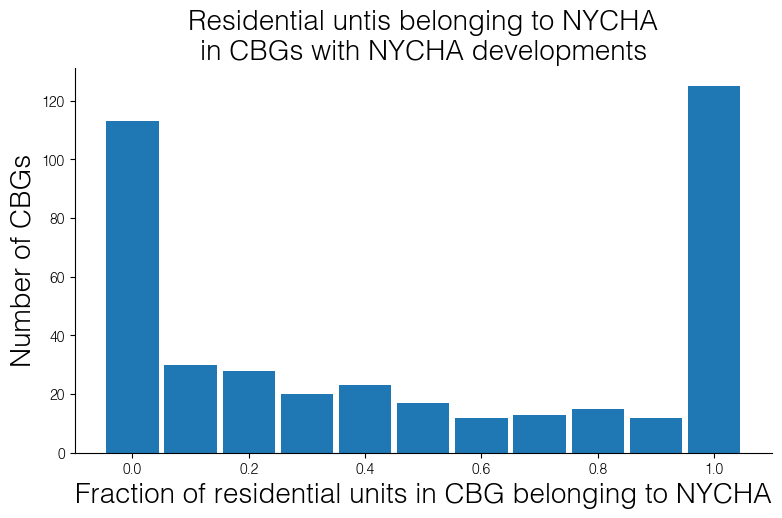

In [12]:
full_CBG_treshold = 1

#Select NYCHA buildings:
NYCHA_mask = pluto_with_cbgs['OWNER'] == 'NYC HOUSING AUTHORITY'
pluto_nycha = pluto_with_cbgs[NYCHA_mask].reset_index(drop=True)

#Find the development of each NYCHA building:
pluto_nycha = gpd.sjoin(pluto_nycha, NYCHA_2025_full_gdf[['DEVELOPMENT', 'geometry']], how='left', predicate='within').drop(columns='index_right').dropna(subset='DEVELOPMENT')

#Find the share of residential units in each NYCHA CBG covered by NCYHA:
NYCHA_share  = pluto_nycha.groupby('idx')['UNITS_RESIDENTIAL_SHARE'].sum()
CBG_groups['NYCHA only'] = NYCHA_share[NYCHA_share >= full_CBG_treshold].index.tolist()
assert len(set(CBG_groups['NYCHA only']) - set(CBG_groups['NYCHA'])) == 0

#Quick viz:
fig, ax = plt.subplots(figsize=(9, 5))
_ = ax.hist(NYCHA_share, rwidth=.9, range=(-.05,1.05), bins=11)
_ = ax.spines[['right', 'top']].set_visible(False)
_ = ax.set_title('Residential untis belonging to NYCHA\nin CBGs with NYCHA developments', fontsize=20)
_ = ax.set_xlabel('Fraction of residential units in CBG belonging to NYCHA', fontsize=20)
_ = ax.set_ylabel('Number of CBGs', fontsize=20)
print(f"There are {len(CBG_groups['NYCHA only'])} ({len(CBG_groups['NYCHA only'])/len(NYC_cbgs):.2%}) CBGs in New York entirely NYCHA")
print(f"There are {len(CBG_groups['NYCHA']) - len(CBG_groups['NYCHA only'])} ({(len(CBG_groups['NYCHA']) - len(CBG_groups['NYCHA only']))/len(NYC_cbgs):.2%}) CBGs in New York partially in NYCHA")

Let's get a geographic control:

In [13]:
#Collect NYCHA neighborhoods:
for buffer in [250, 500]: #meters to define around CBG centroid
    NYCHA_neighborhoods = NYC_cbgs_metric[NYC_cbgs_metric['idx'].isin(CBG_groups['NYCHA only'])].buffer(buffer)
    NYCHA_neighborhoods_union = gpd.GeoDataFrame(geometry=[NYCHA_neighborhoods.unary_union], crs=vars._NY_crs)
    NYCHA_neighborhood_CBGs = gpd.sjoin(NYC_cbgs_metric[NYC_cbgs_metric['idx'].isin(CBG_groups['No NYCHA'])], NYCHA_neighborhoods_union, predicate='intersects', how='inner')
    CBG_groups[f'NYCHA within {buffer} meters'] = NYCHA_neighborhood_CBGs['idx'].astype(int).tolist()

Quick map:

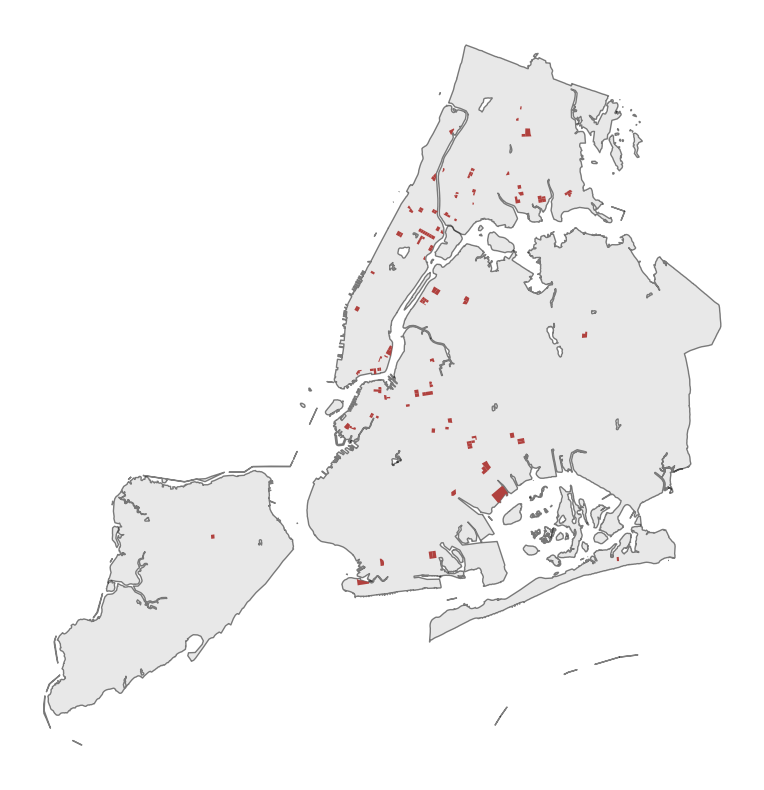

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
ax = NYC_boundary.plot(ax=ax, color='lightgray', alpha=0.5, edgecolor='k')
ax = NYC_cbgs[NYC_cbgs['idx'].isin(CBG_groups['NYCHA only'])].plot(ax=ax, color=CBG_colors[CBG_labels['NYCHA only']], label=CBG_labels['NYCHA only'])
#ax = NYC_cbgs[NYC_cbgs['idx'].isin(CBG_groups['NYCHA within 250 meters'])].plot(ax=ax, color=CBG_colors[CBG_labels['NYCHA within 250 meters']], label=CBG_labels['NYCHA within 250 meters'])
_ = ax.axis('off')
plt.savefig(f'{plots_dir}NYCHA-map.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}NYCHA-map.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 3. Analyzing migration into public housing:

In [15]:
def lineplot(x, ys, labels, ax=None, title=None, ylabel=None, fontsize=20, title_fontsize=20,
             legend=False, legend_cols=None, legend_loc='bottom',
             xlabel='Year',
             ylim=None, y_pct=False,
             colors=None):
    #Get an axis:
    if ax is None: fig, ax = plt.subplots(figsize=(6,4))
    #Plot:
    for i, (y, label) in enumerate(zip(ys, labels)):
        color = colors[i] if colors is not None else None
        _ = ax.plot(x, y, label=label, marker='o', color=color, alpha=0.8)
    #Legend:
    if legend:
        _ = ax.legend(fontsize=fontsize,
                      loc='upper center' if legend_loc=='bottom' else 'lower center',
                      bbox_to_anchor=(0.5, -0.15) if legend_loc=='bottom' else (0.5, 1.),
                      ncol=len(labels) if legend_cols is None else legend_cols,frameon=False)
    #Configure:
    _ = ax.set_title(title, fontsize=title_fontsize)
    _ = ax.set_ylabel(ylabel, fontsize=fontsize)
    _ = ax.set_xlabel(xlabel, fontsize=fontsize)
    _ = ax.tick_params(axis='both', labelsize=fontsize) 
    _ = ax.spines[['right', 'top']].set_visible(False)
    if y_pct: _ = ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
        
    #Line:
    if ax.get_ylim()[0] < 0:
        _ = ax.axhline(0, linestyle='--', alpha=0.8, color='k', zorder=-1)
    else:
        _ = ax.set_ylim(bottom=0)
    #Limits:
    if ylim is not None:
        _ = ax.set_ylim(ylim[0], ylim[1])
    return ax

### 3a. Migration in NYCHA CBGs vs. in other CBGs:

Collect summary quantities per year:

In [16]:
quantities = {}
quantities['out-migration'] = {year: np.array(M.sum(axis=1)).flatten() - M.diagonal() for year, M in M_dict.items()}
quantities['in-migration']  = {year: np.array(M.sum(axis=0)).flatten() - M.diagonal() for year, M in M_dict.items()}
quantities['net-migration'] = {year: np.array(M.sum(axis=0)).flatten() - np.array(M.sum(axis=1)).flatten() for year, M in M_dict.items()}
quantities['population']    = {year: np.array(M.sum(axis=1)).flatten() for year, M in M_dict.items()}
quantities['stayers']       = {year: M.diagonal() for year, M in M_dict.items()}

Compute rates per group:

In [17]:
y_outmigration, y_inmigration, y_netmigration, y_popchange = [], [], [], []
for CBG_group in ['NYCHA only', 'NYCHA within 250 meters', 'No NYCHA']:
    indices = CBG_groups[CBG_group]
    
    #First, collect total out, in, and net-migration rates:
    out_migration_rate = {year:1_000*outmigration[indices].sum()/quantities['population'][year][indices].sum()
                          for year, outmigration in quantities['out-migration'].items()}
    y_outmigration.append(list(out_migration_rate.values()))
    
    in_migration_rate  = {year:1_000*inmigration[indices].sum()/quantities['population'][year][indices].sum()
                          for year, inmigration in quantities['in-migration'].items()}
    y_inmigration.append(list(in_migration_rate.values()))

    y_netmigration.append([in_migration_rate[y] - out_migration_rate[y] for y in range(2011,2020)])

    #Population change:
    population_total = {year: population[indices].sum() for year,population in quantities['population'].items()}
    population_change = {2010:0.}|{year: population_total[year]/population_total[year-1] - 1 for year in sorted(population_total)[1:]}
    y_popchange.append(list(population_change.values()))

Plot:

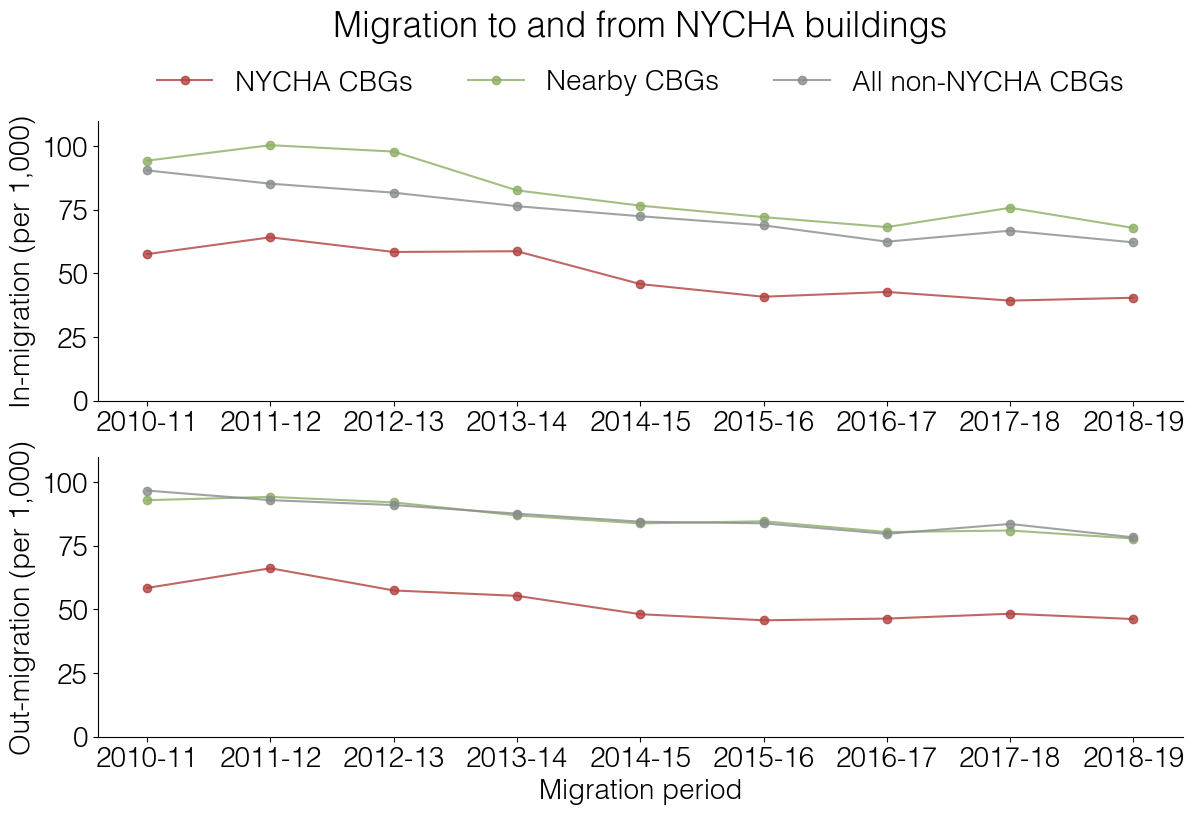

In [18]:
fig, Axes = plt.subplots(figsize=(14,8), nrows=2, gridspec_kw={'hspace':.2})
labels = ['NYCHA CBGs', 'Nearby CBGs', 'All non-NYCHA CBGs']
colors = [CBG_colors.get(l, 'blue') for l in labels]
x_vals = [f"20{y}-{y+1}" for y in range(10,19)]

#Plot:
Axes[0] = lineplot(x_vals, y_inmigration, labels, ax=Axes[0], title='Migration to and from NYCHA buildings\n\n', ylabel='In-migration (per 1,000)', xlabel=None, ylim=(0,110), legend=True, title_fontsize=25, legend_loc='top', colors=colors)
Axes[1] = lineplot(x_vals, y_outmigration, labels, ax=Axes[1], title=None, ylabel='Out-migration (per 1,000)', xlabel='Migration period', ylim=(0,110), colors=colors)

plt.savefig(f'{plots_dir}NYCHA-rates.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}NYCHA-rates.pdf', dpi=300, bbox_inches='tight')
plt.show()

### 3b. Demographics moving into and out of NYCHA CBGs vs. other CBGs:

Let's evaluate the share of in-movers per group (demographic groups, but also within NYC, out of state, and within NYCHA):

In [19]:
income_groups = ['Bottom income quartile', '2nd income quartile', '3rd income quartile', 'Top income quartile']
movers_by_group_yearly, movers_by_distance_yearly = {'out':{}, 'in':{}}, {'out':{}, 'in':{}}

#Iterate over migration matrices:
for migration_year, M in tqdm(M_dict.items()):
    
    #Collect demographic groups:
    demographics_raw = ACS_CBG_dem[migration_year-1]
    median_income = demographics_raw['Household Income']['Median income'].values
    CBG_demographic_groups = eval.get_demographic_groups(demographics_raw, income_q=len(income_groups), income_labels=income_groups)

    #Separately for out and in moves, and use the transpose for the latter:
    for mover_direction in ['out', 'in']:
        matrix_with_direction = M if mover_direction == 'out' else M.T
        
        #Collect moves by demographics and upwards:
        CBG_moves_by_group = eval.count_moves_by_group(matrix_with_direction, CBG_demographic_groups)
        CBG_moves_upwards = pd.DataFrame({'Higher-income': eval.count_moves_upwards(matrix_with_direction, median_income, outmovers=mover_direction=='out')})
        #Merge, log in the baseline, and save:
        all_CBG_moves_by_group = pd.concat([CBG_moves_by_group, CBG_moves_upwards],axis=1)
        all_CBG_moves_by_group[f'{mover_direction}-migration'] = quantities[f'{mover_direction}-migration'][migration_year]
        movers_by_group_yearly[mover_direction][migration_year] = all_CBG_moves_by_group

        #Collect moves by distance:
        CBG_moves_NYCHA = eval.count_moves_within_CBGs(matrix_with_direction, CBG_groups['NYCHA only'], name='NYCHA')
        CBG_moves_NYC   = eval.count_moves_within_CBGs(matrix_with_direction, NYC_cbgs['idx'].astype(int).values, name='New York City')
        CBG_moves_NYS   = eval.count_moves_within_CBGs(matrix_with_direction, us_gdf[us_gdf['STATE'] == '36']['idx'].astype(int).values, name='New York State')
        #Merge, log in the baseline, and save:
        all_CBG_moves_by_distance = pd.concat([CBG_moves_NYCHA, CBG_moves_NYC, CBG_moves_NYS], axis=1)
        all_CBG_moves_by_distance[f'{mover_direction}-migration'] = quantities[f'{mover_direction}-migration'][migration_year]
        movers_by_distance_yearly[mover_direction][migration_year] = all_CBG_moves_by_distance

100%|█████████████████████████████████████████████| 9/9 [06:24<00:00, 42.72s/it]


Now we aggregate and plot. First let's do time series for all:

In [20]:
show_plots = False

demographic_groups = list(movers_by_group_yearly['out'][2011].columns[:-1])
distance_groups = list(movers_by_distance_yearly['out'][2011].columns[:-1])

#Let's do for both directions (tho out-migration is inherently more interesting):
for mover_direction in ['out', 'in']:
    #We will go over the distance and demographic based groups:
    for groups, yearly_counts in [(distance_groups, movers_by_distance_yearly), (demographic_groups, movers_by_group_yearly)]:
        #One group per plot:
        for group in groups:
            y = []
            for CBG_group in ['NYCHA only', 'NYCHA within 250 meters', 'No NYCHA']:
                indices = CBG_groups[CBG_group]
                group_mover_rate = {year: df[group].iloc[indices].sum()/df[f'{mover_direction}-migration'].iloc[indices].sum()
                                    for year, df in yearly_counts[mover_direction].items()}
                y.append(list(group_mover_rate.values()))
            title = f"{mover_direction.capitalize()}-movers {'to' if mover_direction=='out' else 'in'} {group} CBGs\n\n"
            if show_plots:
                fig, ax = plt.subplots(figsize=(15, 5))
                ax = lineplot(x_vals, y, labels, ax=ax,
                              title=title,
                              ylabel=f'Share of {mover_direction}-movers',
                              xlabel='Migration Period', y_pct=True, ylim=(0,1),
                              legend=True, legend_loc='top', colors=colors)
                plt.show()
            else:
                print(title[:-2])
            display((100*pd.DataFrame(y, index=labels, columns=x_vals)).astype(int))

Out-movers to NYCHA CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,13,13,14,13,14,12,14,12,10
Nearby CBGs,2,2,1,1,1,1,1,1,1
All non-NYCHA CBGs,0,1,0,0,0,0,0,0,0


Out-movers to New York City CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,79,80,79,77,75,71,69,68,63
Nearby CBGs,71,71,69,68,65,63,59,61,59
All non-NYCHA CBGs,70,70,69,67,65,62,58,60,58


Out-movers to New York State CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,85,85,84,83,80,77,75,76,70
Nearby CBGs,80,78,77,76,73,71,68,70,68
All non-NYCHA CBGs,81,80,79,77,75,73,70,72,70


Out-movers to Plurality Asian CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,3,2,2,2,2,3,3,3,3
Nearby CBGs,4,3,3,3,3,3,3,4,4
All non-NYCHA CBGs,6,5,6,6,6,6,6,6,6


Out-movers to Plurality Black CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,34,35,34,34,34,34,34,32,29
Nearby CBGs,25,25,23,23,23,23,22,22,20
All non-NYCHA CBGs,18,18,17,17,17,16,16,16,15


Out-movers to Plurality Hispanic CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,35,37,39,38,37,33,32,32,33
Nearby CBGs,21,23,21,20,22,19,19,20,19
All non-NYCHA CBGs,17,19,18,18,18,17,16,16,16


Out-movers to Plurality White CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,26,23,23,23,24,28,29,31,33
Nearby CBGs,49,48,51,51,51,53,54,52,55
All non-NYCHA CBGs,58,56,57,58,58,59,61,60,60


Out-movers to Rural CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,1,1,1,1,1,1,2,3,4
Nearby CBGs,1,2,1,1,2,2,2,3,3
All non-NYCHA CBGs,1,1,1,2,2,2,3,3,3


Out-movers to Urban CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,98,98,98,98,98,98,97,96,95
Nearby CBGs,98,97,98,98,97,97,97,96,96
All non-NYCHA CBGs,98,98,98,97,97,97,96,96,96


Out-movers to 2nd income quartile CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,19,19,19,17,19,18,18,17,20
Nearby CBGs,18,20,19,18,18,17,17,18,18
All non-NYCHA CBGs,18,18,19,18,17,16,16,16,16


Out-movers to 3rd income quartile CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,18,16,15,15,15,17,18,19,18
Nearby CBGs,22,21,21,22,23,22,22,23,22
All non-NYCHA CBGs,24,23,23,23,24,23,24,24,24


Out-movers to Bottom income quartile CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,47,51,51,52,50,48,48,44,42
Nearby CBGs,26,26,23,23,22,21,20,20,19
All non-NYCHA CBGs,18,19,17,17,17,17,16,16,15


Out-movers to Top income quartile CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,14,12,13,13,14,15,15,18,18
Nearby CBGs,33,31,35,35,36,38,38,37,39
All non-NYCHA CBGs,39,37,39,40,40,42,42,42,42


Out-movers to Higher-income CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,83,81,81,80,82,80,80,81,83
Nearby CBGs,58,55,56,56,54,57,57,58,58
All non-NYCHA CBGs,56,54,54,53,54,55,56,56,56


In-movers in NYCHA CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,13,13,14,13,15,14,15,14,11
Nearby CBGs,2,2,2,2,1,1,1,1,1
All non-NYCHA CBGs,0,1,0,0,0,0,0,0,0


In-movers in New York City CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,86,87,84,85,81,80,76,74,68
Nearby CBGs,76,76,76,77,75,75,74,74,71
All non-NYCHA CBGs,74,76,76,77,75,76,74,75,73


In-movers in New York State CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,89,90,87,87,83,83,79,77,72
Nearby CBGs,82,81,82,82,80,80,79,79,77
All non-NYCHA CBGs,83,83,83,83,82,82,80,81,80


In-movers in Plurality Asian CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,4,4,3,5,3,3,2,3,3
Nearby CBGs,4,4,4,4,4,5,4,5,5
All non-NYCHA CBGs,7,7,8,8,8,8,8,9,8


In-movers in Plurality Black CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,37,35,34,34,35,34,35,35,29
Nearby CBGs,27,26,25,24,24,23,23,23,22
All non-NYCHA CBGs,18,19,18,17,17,17,17,17,17


In-movers in Plurality Hispanic CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,41,45,45,42,42,41,41,38,40
Nearby CBGs,24,25,26,26,26,24,24,25,25
All non-NYCHA CBGs,20,23,22,22,23,22,22,22,22


In-movers in Plurality White CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,17,14,15,17,18,19,20,22,26
Nearby CBGs,42,43,43,44,44,46,46,45,46
All non-NYCHA CBGs,53,50,51,51,51,52,51,49,50


In-movers in Rural CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,1,0,0,1,1,1,2,2,3
Nearby CBGs,1,1,1,1,1,1,2,2,2
All non-NYCHA CBGs,1,1,1,1,1,1,1,1,2


In-movers in Urban CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,98,99,99,98,98,98,97,97,96
Nearby CBGs,98,98,98,98,98,98,97,97,97
All non-NYCHA CBGs,98,98,98,98,98,98,98,98,97


In-movers in 2nd income quartile CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,19,20,19,18,18,18,17,19,19
Nearby CBGs,19,21,20,20,20,19,19,18,20
All non-NYCHA CBGs,19,20,21,20,20,19,19,18,19


In-movers in 3rd income quartile CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,14,13,12,12,14,13,15,14,15
Nearby CBGs,21,19,20,21,21,21,21,21,21
All non-NYCHA CBGs,23,23,23,23,24,23,24,24,24


In-movers in Bottom income quartile CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,57,58,59,59,57,57,56,54,51
Nearby CBGs,32,30,29,28,27,26,27,27,25
All non-NYCHA CBGs,22,23,21,21,20,20,20,21,19


In-movers in Top income quartile CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,9,7,8,9,10,10,11,11,14
Nearby CBGs,27,28,28,29,31,32,32,32,33
All non-NYCHA CBGs,33,32,34,34,35,35,35,35,35


In-movers in Higher-income CBGs


,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19
NYCHA CBGs,16,19,17,17,18,21,21,22,18
Nearby CBGs,41,41,41,45,49,49,49,44,47
All non-NYCHA CBGs,46,49,50,52,52,54,55,54,54


Let's do aggregated bar plots (we can re-use our CBG error function):

In-mover share (%):


,NYCHA CBGs,Nearby CBGs,All non-NYCHA CBGs
Plurality Asian,4.0,5.0,8.0
Plurality Black,35.0,25.0,18.0
Plurality Hispanic,42.0,26.0,23.0
Plurality White,19.0,45.0,51.0
Rural,2.0,2.0,2.0
Urban,98.0,98.0,98.0
2nd income quartile,19.0,20.0,20.0
3rd income quartile,14.0,21.0,24.0
Bottom income quartile,57.0,28.0,21.0
Top income quartile,10.0,31.0,35.0


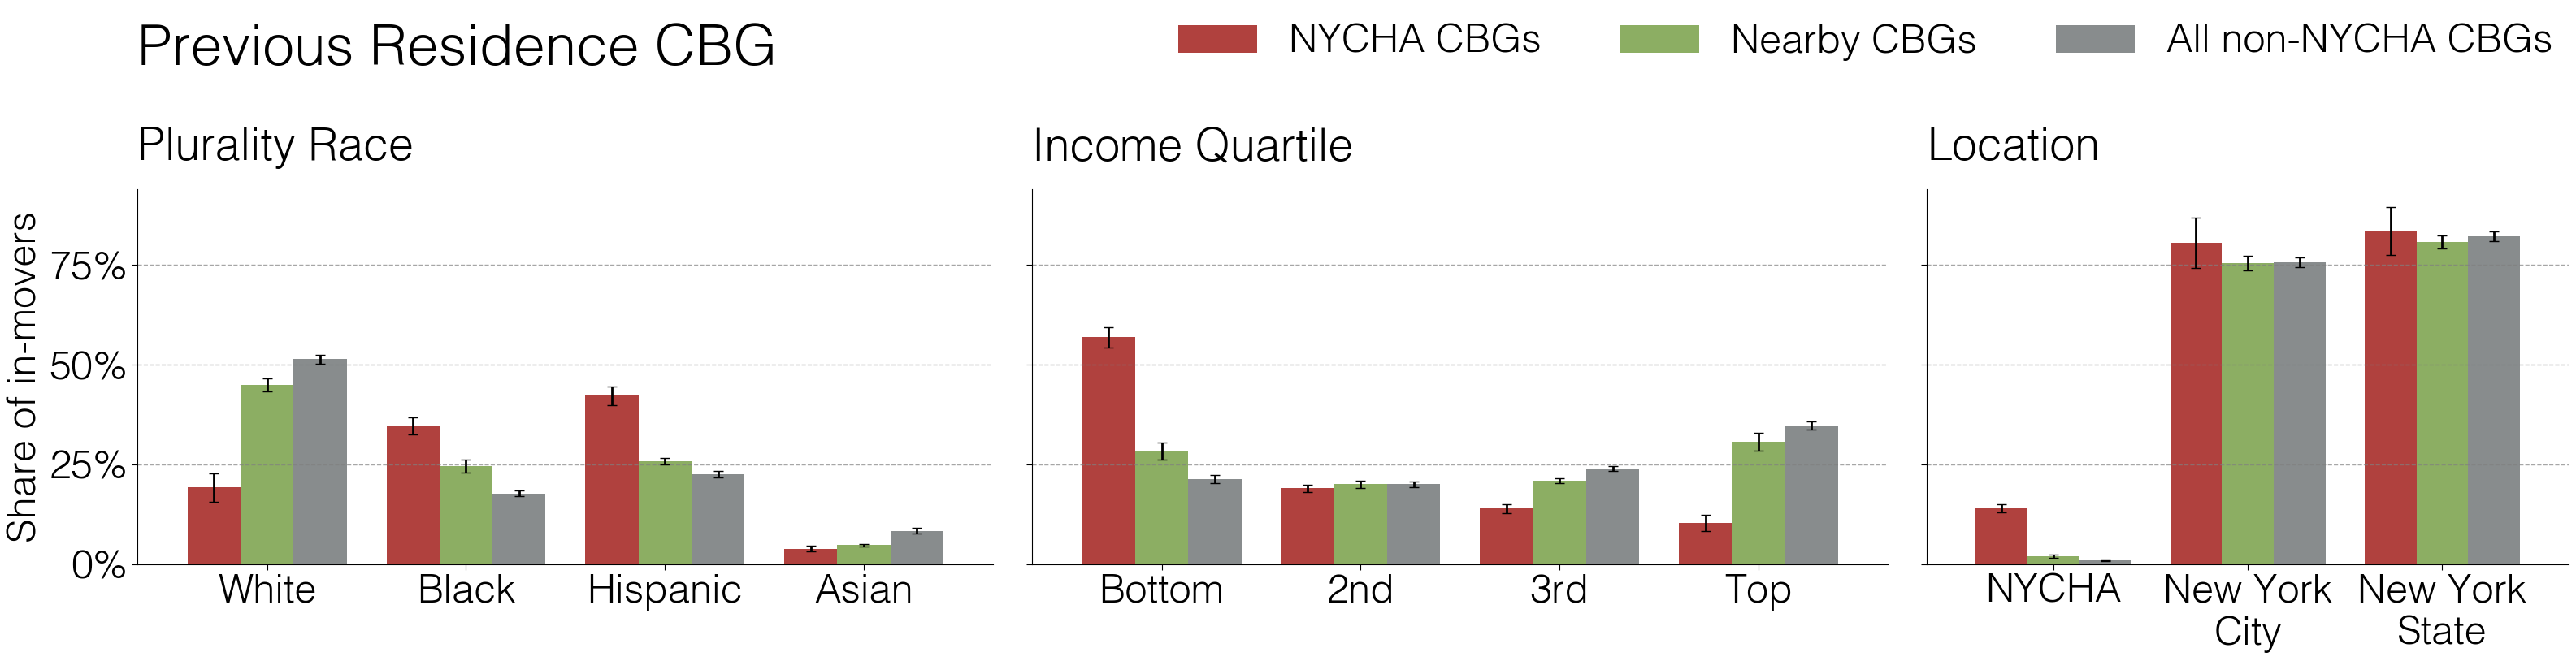

Out-mover share (%):


,NYCHA CBGs,Nearby CBGs,All non-NYCHA CBGs
Plurality Asian,3.0,4.0,6.0
Plurality Black,34.0,23.0,17.0
Plurality Hispanic,36.0,21.0,18.0
Plurality White,27.0,52.0,59.0
Rural,2.0,2.0,2.0
Urban,98.0,98.0,98.0
2nd income quartile,19.0,19.0,18.0
3rd income quartile,17.0,22.0,24.0
Bottom income quartile,49.0,23.0,17.0
Top income quartile,15.0,36.0,41.0


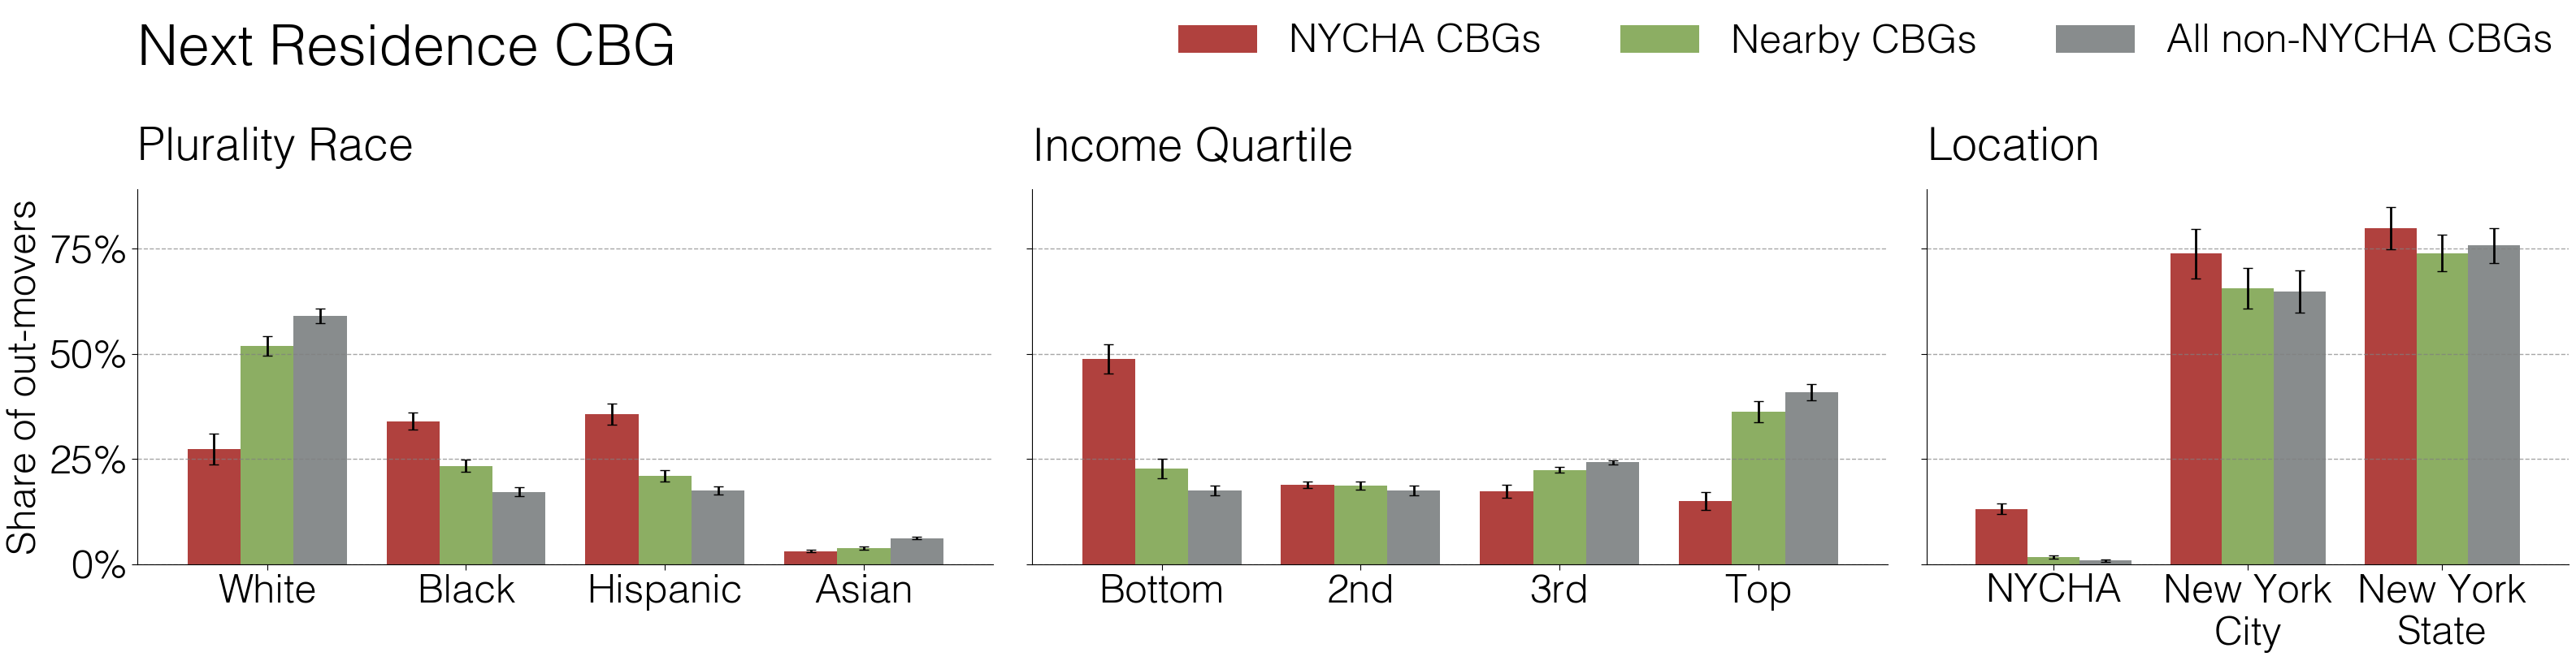

In [21]:
#Select to plot:
demographic_groups_of_interest = {'Plurality Race': ['Plurality White', 'Plurality Black', 'Plurality Hispanic', 'Plurality Asian'], 
                                  'Income Quartile': ['Bottom income quartile', '2nd income quartile', '3rd income quartile', 'Top income quartile'],
                                  'Location':['NYCHA', 'New York City', 'New York State']}
renames = dict(zip(np.concatenate([x for x in demographic_groups_of_interest.values()]),
                   ['White', 'Black', 'Hispanic', 'Asian', 'Bottom', '2nd', '3rd', 'Top', 'NYCHA', 'New York\nCity', 'New York\nState']))

#Let's do for both directions (tho out-migration is inherently more interesting):
for mover_direction in ['in', 'out']:

    #Create a mean and a standard deviation dataframe:
    aggregates = {'est':[], 'std':[]}
    for CBG_group in ['NYCHA only', 'NYCHA within 250 meters', 'No NYCHA']:
        #Collect mean and sd of mover rates to each group:
        indices = CBG_groups[CBG_group]
        group_mover_rate = pd.DataFrame({year: df.iloc[indices].sum()/df[f'{mover_direction}-migration'].iloc[indices].sum()
                                         for year, df in movers_by_group_yearly[mover_direction].items()})
        dist_mover_rate = pd.DataFrame({year: df.iloc[indices].sum()/df[f'{mover_direction}-migration'].iloc[indices].sum()
                                             for year, df in movers_by_distance_yearly[mover_direction].items()})
        all_rates = pd.concat([group_mover_rate, dist_mover_rate])
        aggregates['est'].append((all_rates.mean(axis=1)).rename(CBG_labels[CBG_group]))
        aggregates['std'].append((all_rates.std(axis=1)).rename(CBG_labels[CBG_group]))
    for key, value in aggregates.items(): aggregates[key] = pd.concat(value,axis=1)
    
    #Print the rates:
    print(f'{mover_direction.capitalize()}-mover share (%):')
    display(round(100*aggregates['est'],0))
    
    #Clean up dfs:
    rows = [(group, subgroup) for group, subgroups in demographic_groups_of_interest.items() for subgroup in subgroups]
    for key, df in aggregates.items():
        df = df.loc[[subgroup for _, subgroup in rows]]
        df.index = pd.MultiIndex.from_tuples(rows)
        aggregates[key] = df.rename(index=renames, level=1)
    
    #Plot:
    Axes = viz.plot_CBG_population_error(est_df=aggregates['est'],
                                         std_df=aggregates['std'],
                                         y_label=f'Share of {mover_direction}-movers', dataset_colors=CBG_colors,
                                         title_fontsize=40, textsize=35, base_width=3.5, spacing=.05, grid=True, height=6)
    _ = Axes[-1].legend(bbox_to_anchor=(1., 1.3,), loc='lower right', fontsize=35, borderaxespad=0, ncols=3, frameon=False)
    _ = Axes[0].text(s='Next Residence CBG' if mover_direction=='out' else 'Previous Residence CBG', x=0, y=1.3, transform=Axes[0].transAxes, va='bottom', ha='left', fontsize=50)
    plt.savefig(f'{plots_dir}NYCHA-{mover_direction}-demographic.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{plots_dir}NCYHA-{mover_direction}-demographic.pdf', dpi=300, bbox_inches='tight')
    plt.show()